In [1]:
import pandas as pd
import numpy as np
from glob import glob
import os
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

plt.style.use('ggplot')

In [2]:
input_root = "../../data/output/xgbooster/"
monitor_root = "../../data/csv/monitor"
test_root = "../../data/csv/aqi_csv_test/"

In [3]:
# load coordinates
monitor_coords = pd.read_csv(os.path.join(monitor_root, "monitor_coords.csv"),
                             index_col='id')

## Report CV R2

In [ ]:
for target_name in tqdm_notebook(["API", "PM10", "PM2.5", "O3", "SO2", "NO2", "CO"]):
    files = glob(os.path.join(input_root, target_name, "test/", "*.csv"))
    output = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    output.set_index('id', inplace=True)
    output = output.dropna()
    output['date'] = pd.to_datetime(output['date'])
    output = output.assign(
        year = output.date.dt.year,
        week = output.date.dt.week,
        biweek = ((output.date.dt.week + 1) / 2).astype(int))
    grouped = output.groupby('id')
    # day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.true.values,
                                 group.pred.values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "day_r2_cv.csv"))
    # 7-day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.groupby(['year', 'week']).true.mean().values,
                                 group.groupby(['year', 'week']).pred.mean().values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "7day_r2_cv.csv"))
    # 14-day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.groupby(['year', 'biweek']).true.mean().values,
                                 group.groupby(['year', 'biweek']).pred.mean().values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "14day_r2_cv.csv"))

## Calculate Test R2

In [ ]:
files = glob(os.path.join(test_root, "*.csv"))
test = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
test['date'] = pd.to_datetime(test['date'])
test.set_index(['id', 'date'], inplace=True)

for target_name in tqdm_notebook(["API", "PM10", "PM2.5", "O3", "SO2", "NO2", "CO"]):
    # load true data
    target = test[["target_" + target_name]]
    target.columns = ['true']
    # load pred data
    files = glob(os.path.join(input_root, target_name, "pred/*.csv"))
    output = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    output['date'] = pd.to_datetime(output['date'])
    output.set_index(['id', 'date'], inplace=True)
    target = target.join(output).dropna().reset_index('date')
    target = target.assign(
        year = target.date.dt.year,
        week = target.date.dt.week,
        biweek = ((target.date.dt.week + 1) / 2).astype(int))
    grouped = target.groupby('id')
    # day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.true.values,
                                 group.pred.values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "day_r2_test.csv"))
    # 7-day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.groupby(['year', 'week']).true.mean().values,
                                 group.groupby(['year', 'week']).pred.mean().values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "7day_r2_test.csv"))
    # 14-day
    r2 = pd.DataFrame([[station_id,
                        r2_score(group.groupby(['year', 'biweek']).true.mean().values,
                                 group.groupby(['year', 'biweek']).pred.mean().values)] for station_id, group in grouped],
                      columns=['id', 'r2'])
    r2.to_csv(os.path.join(input_root, target_name, "14day_r2_test.csv"))

## Drop Stations

In [4]:
target_name = "O3"
drop_file = "day_r2_cv.csv"
drop = pd.read_csv(os.path.join(input_root, target_name, drop_file))
ids = set(drop.loc[drop.r2 >= np.percentile(drop.r2, q=50), 'id'])

## Visualize

In [5]:
for file in ["day_r2_test.csv", "7day_r2_test.csv", "14day_r2_test.csv",
             "day_r2_cv.csv", "7day_r2_cv.csv", "14day_r2_cv.csv"]:
    r2 = pd.read_csv(os.path.join(input_root, target_name, file), index_col='id')
    ids = ids.intersection(set(r2.index))
    r2 = r2.loc[list(ids), :].dropna()
    print(
        file,
        np.percentile(r2.r2, q=5),
        np.percentile(r2.r2, q=10),
        np.median(r2.r2),
        np.percentile(r2.r2, q=90),
        np.percentile(r2.r2, q=95))

day_r2_test.csv -0.473044299458 -0.0116497385535 0.531794560031 0.716370096734 0.752403853761
7day_r2_test.csv -0.891359465952 -0.246170327161 0.59499675154 0.795508179021 0.833960853025
14day_r2_test.csv -1.03928370622 -0.199902835292 0.68617969534 0.894691957628 0.917507802199
day_r2_cv.csv 0.434168692663 0.446474661435 0.549887906733 0.701524248598 0.734420940501
7day_r2_cv.csv 0.542193041149 0.567681873933 0.688170831427 0.844590033386 0.869332885106
14day_r2_cv.csv 0.560194375789 0.591902976631 0.73367805482 0.880214785142 0.900179688292


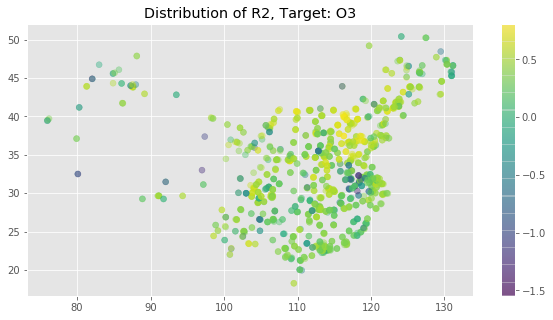

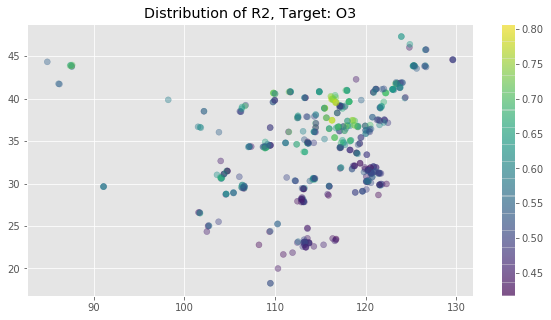

In [6]:
target_name = "O3"
r2 = pd.read_csv(os.path.join(input_root, target_name, "day_r2_cv.csv"), index_col='id')
r2 = r2.join(monitor_coords)
plt.figure(figsize=(10, 5))
plt.scatter(x=r2.long, y=r2.lat, c=r2.r2, cmap="viridis", alpha=0.4)
plt.title("Distribution of R2, Target: {}".format(target_name))
plt.colorbar()
plt.show()
r2 = pd.read_csv(os.path.join(input_root, target_name, "day_r2_cv.csv"), index_col='id')
r2 = r2.join(monitor_coords)
r2 = r2.loc[list(ids), :].dropna()
plt.figure(figsize=(10, 5))
plt.scatter(x=r2.long, y=r2.lat, c=r2.r2, cmap="viridis", alpha=0.4)
plt.title("Distribution of R2, Target: {}".format(target_name))
plt.colorbar()
plt.show()

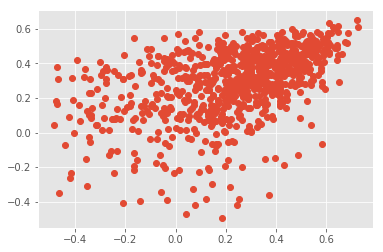

In [8]:
target_name = "NO2"
df1 = pd.read_csv(os.path.join(input_root, target_name, "day_r2_test.csv"), index_col='id')
df2 = pd.read_csv(os.path.join(input_root, target_name, "day_r2_cv.csv"), index_col='id')
df = df1.join(df2, lsuffix="_1", rsuffix="_2")
df = df[(df.r2_1 > -0.5) & (df.r2_2 > -0.5)].dropna()
plt.plot(df.r2_1, df.r2_2, 'o')
plt.show()

## Save Output

In [4]:
drop_file = "day_r2_cv.csv"

In [5]:
files = glob(os.path.join(test_root, "*.csv"))
test = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
test['date'] = pd.to_datetime(test['date'])
test.set_index(['id', 'date'], inplace=True)

for target_name in tqdm_notebook(["API", "PM10", "PM2.5", "O3", "SO2", "NO2", "CO"]):
    # drop half of the stations
    drop = pd.read_csv(os.path.join(input_root, target_name, drop_file))
    ids = set(drop.loc[drop.r2 >= np.percentile(drop.r2, q=50), 'id'])
    # load training data
    files = glob(os.path.join(input_root, target_name, "test/", "*.csv"))
    output = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    output.set_index('id', inplace=True)
    ids_ = ids.intersection(set(output.index))
    output = output.loc[list(ids_), :]
    output = output.dropna()
    output.to_csv(os.path.join(input_root, target_name, "train_output.csv"))
    # load pred data
    files = glob(os.path.join(input_root, target_name, "pred/*.csv"))
    output = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)
    output.set_index('id', inplace=True)
    ids_ = ids.intersection(set(output.index))
    output = output.loc[list(ids_), :]
    output.to_csv(os.path.join(input_root, target_name, "prediction_output.csv"))
    # load test data
    target = test[["target_" + target_name]]
    target.columns = ['true']
#     output = pd.read_csv(os.path.join(input_root, target_name, "prediction_output.csv"))
    output['date'] = pd.to_datetime(output['date'])
    output = output.reset_index().set_index(['id', 'date'])
    target = output.join(target).dropna()
#     ids_ = ids.intersection(set(target.index))
#     target = target.loc[(list(ids_), slice(None)), :]
    target.to_csv(os.path.join(input_root, target_name, "test_output.csv"))

HBox(children=(IntProgress(value=0, max=7), HTML(value='')))